In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
from gplately import pygplates
from scipy import ndimage
from scipy.spatial import cKDTree
from joblib import Parallel, delayed

# agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/SampleData/Rasters/M2020_AgeGrids/"
# agegrid_filename = agegrid_dir + "Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"

reconstruction_times = np.arange(0,171)

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [15]:
LIP_conjugates_filename = "data/LIP_conjugates/LIP_conjugates_0Ma.shp"
LIPs_filename = "data/Whittaker_etal_2015_LIPs.gpmlz"
LIPs = pygplates.FeatureCollection(LIPs_filename)
LIPs.add(pygplates.FeatureCollection(LIPs_filename))

reconstructed_LIPs = model.reconstruct(LIPs, 0)

In [17]:
# create geopandas dataframe
import geopandas as gpd
df_platforms = gpd.GeoDataFrame({"geometry": gplately.plot.pygplates_to_shapely(reconstructed_LIPs)},
                                geometry="geometry")

In [19]:
shp_LIPs = gplately.plot.pygplates_to_shapely(reconstructed_LIPs)

In [40]:
for LIP in reconstructed_LIPs:
    geometry = LIP.get_reconstructed_geometry()
    break 

In [31]:
for shp in shp_LIPs:
    break

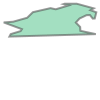

In [33]:
shp.centroid

In [30]:
shp.get_geometry()

<Axes: >

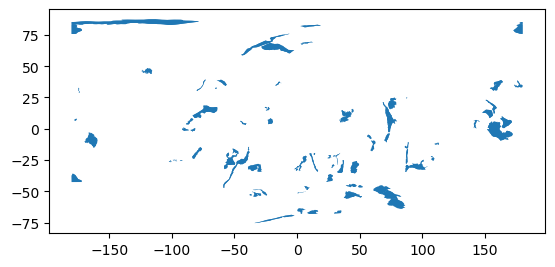

In [18]:
df_platforms.plot()

In [84]:
def reconstruct_LIP_subduction(time, dtol=50, return_LIPs=False):
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    
    # reconstruct seamount and extract points on sphere
    LIPs = pygplates.FeatureCollection(LIPs_filename)
    LIPs.add(pygplates.FeatureCollection(LIPs_filename))
    reconstructed_LIPs = model.reconstruct(LIPs, time)
    

    # find the nearest trench segment for each LIP
    xt, yt, zt = gplately.tools.lonlat2xyz(trench_lons, trench_lats)
    tree_trench = cKDTree(np.c_[xt,yt,zt])
    
    trench_LIP_lons = []
    trench_LIP_lats = []
    
    for LIP in reconstructed_LIPs:
        LIP_coords = LIP.get_reconstructed_geometry().get_points().to_lat_lon_array()
        LIP_lons = LIP_coords[:,1]
        LIP_lats = LIP_coords[:,0]
        xl, yl, zl = gplately.tools.lonlat2xyz(LIP_lons, LIP_lats)
        
        dist_to_LIP, idx_LIP = tree_trench.query(np.c_[xl, yl, zl])
        dist_to_LIP *= gplately.EARTH_RADIUS
        mask_trench_LIP = dist_to_LIP <= dtol

        trench_LIP_lons.extend(trench_lons[idx_LIP[mask_trench_LIP]])
        trench_LIP_lats.extend(trench_lats[idx_LIP[mask_trench_LIP]])
        

#     # remove duplicate entries
#     sz_coords = np.c_[sz_lons, sz_lats]
#     unique_sz_coords = np.unique(sz_coords, axis=1)
#     print(unique_sz_coords.shape, sz_coords.shape)
    
    if return_LIPs:
        return reconstructed_LIPs, np.array(trench_LIP_lons), np.array(trench_LIP_lats)
    else:
        return np.array(trench_LIP_lons), np.array(trench_LIP_lats)

In [85]:
reconstructed_LIPs, LIP_lons, LIP_lats = reconstruct_LIP_subduction(0, return_LIPs=True)

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


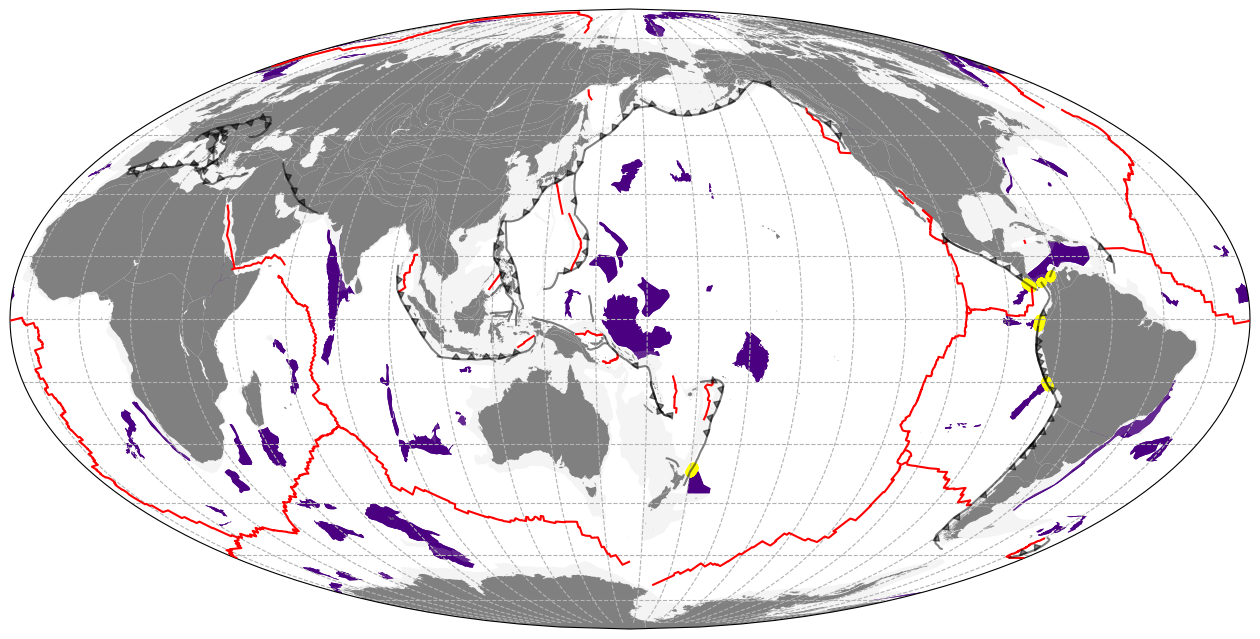

In [86]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_feature(ax, reconstructed_LIPs, color='indigo')
gplot.plot_continents(ax, facecolor='0.8', alpha=0.2)
gplot.plot_coastlines(ax, color='0.5')
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

ax.scatter(LIP_lons, LIP_lats, c='yellow', transform=ccrs.PlateCarree())

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)


In [87]:
# Use LokyBackend to protect the netCDF routine
LIP_data = Parallel(n_jobs=-3, backend='loky', verbose=1)\
    (delayed(reconstruct_LIP_subduction) (time,) for time in reconstruction_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   23.1s
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done 171 out of 171 | elapsed:  1.6min finished


In [89]:
LIP_data_dict = dict()

for i, time in enumerate(reconstruction_times):
    LIP_data_dict[str(time)] = LIP_data[i]
    
np.savez_compressed('subducted_LIP_data.npz', **LIP_data_dict)